<a href="https://colab.research.google.com/github/antonellagambarte/procesamiento_del_lenguaje_I/blob/main/Desafio2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import os
import platform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import text_to_word_sequence

import multiprocessing
try:
  from gensim.models import Word2Vec
except:
  !pip install gensim
  from gensim.models import Word2Vec

from gensim.models.callbacks import CallbackAny2Vec

from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

  Carga del dataset

In [29]:
# Descarga de carpeta de dataset
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [30]:
os.listdir("./songs_dataset/")

['Kanye_West.txt',
 'lil-wayne.txt',
 'blink-182.txt',
 'eminem.txt',
 'bob-marley.txt',
 'michael-jackson.txt',
 'amy-winehouse.txt',
 'bruce-springsteen.txt',
 'alicia-keys.txt',
 'bob-dylan.txt',
 'ludacris.txt',
 'bruno-mars.txt',
 'rihanna.txt',
 'nursery_rhymes.txt',
 'prince.txt',
 'Lil_Wayne.txt',
 'cake.txt',
 'kanye.txt',
 'dickinson.txt',
 'lin-manuel-miranda.txt',
 'lorde.txt',
 'al-green.txt',
 'joni-mitchell.txt',
 'r-kelly.txt',
 'leonard-cohen.txt',
 'notorious-big.txt',
 'nickelback.txt',
 'adele.txt',
 'patti-smith.txt',
 'bjork.txt',
 'radiohead.txt',
 'janisjoplin.txt',
 'kanye-west.txt',
 'missy-elliott.txt',
 'bieber.txt',
 'britney-spears.txt',
 'jimi-hendrix.txt',
 'johnny-cash.txt',
 'beatles.txt',
 'drake.txt',
 'dr-seuss.txt',
 'dj-khaled.txt',
 'nirvana.txt',
 'notorious_big.txt',
 'paul-simon.txt',
 'dolly-parton.txt',
 'nicki-minaj.txt',
 'lady-gaga.txt',
 'disney.txt']

El artista elegido para realizar el desafío es Michael Jackson.

In [31]:
df = pd.read_csv('songs_dataset/michael-jackson.txt', sep='/n', header=None)
df.head()

/tmp/ipython-input-2822025462.py:1: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



,0
0,[Spoken Intro:]
1,You ever want something
2,that you know you shouldn't have
3,"The more you know you shouldn't have it,"
4,The more you want it


In [32]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 9484


## **Creación de vectores**

Preprocesamiento:

A continuación, se recorre cada línea del dataframe, se convierte la línea en una lista de palabras y se guarda todas esas listas en sentence_tokens.

sentence_tokens es una lista de listas, donde cada sublista son las palabras (tokens) de una línea de canción.

In [33]:
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

sentence_tokens[:2]

[['spoken', 'intro'], ['you', 'ever', 'want', 'something']]

Clase personalizada para registrar el loss

In [34]:
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

Modelo Skipgram

In [35]:
# Estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=300,# dimensionalidad de los vectores
                     negative=20,    # cantidad de negative samples
                     workers=1,
                     sg=1)           # modelo skipgram

Se construye el vocabulario con las palabras tokenizadas

In [36]:
w2v_model.build_vocab(sentence_tokens)

In [37]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 9484


In [38]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 1000


Entrenamiento de modelo con el callback personalizado

In [39]:
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=30,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 332195.875
Loss after epoch 1: 227160.0625
Loss after epoch 2: 226886.4375
Loss after epoch 3: 220579.8125
Loss after epoch 4: 191716.8125
Loss after epoch 5: 180949.5
Loss after epoch 6: 173434.75
Loss after epoch 7: 166188.5
Loss after epoch 8: 162249.75
Loss after epoch 9: 156011.625
Loss after epoch 10: 144920.125
Loss after epoch 11: 138371.5
Loss after epoch 12: 135980.5
Loss after epoch 13: 134118.75
Loss after epoch 14: 133386.75
Loss after epoch 15: 131142.0
Loss after epoch 16: 131250.75
Loss after epoch 17: 129227.25
Loss after epoch 18: 129950.25
Loss after epoch 19: 128118.0
Loss after epoch 20: 127296.75
Loss after epoch 21: 127572.5
Loss after epoch 22: 127668.75
Loss after epoch 23: 126239.0
Loss after epoch 24: 124603.5
Loss after epoch 25: 125834.5
Loss after epoch 26: 120929.5
Loss after epoch 27: 115384.0
Loss after epoch 28: 115261.0
Loss after epoch 29: 115863.5


(939805, 1490670)

## **Términos de interés**

Dado que el el artista elegido es Michael Jackson, se eligieron palabras que se creen representativas de sus canciones. En este caso, las palabras love (asociada tanto a vínculos como temáticas sociales), dance (algo característico del artista) y people (también relacionado a temáticas sociales).

**Más relacionadas:**

In [40]:
# Palabras más similares
print("Similares a 'love':")
w2v_model.wv.most_similar(positive=["love"], topn=10)

Similares a 'love':


[('summer', 0.5443717837333679),
 ('rarest', 0.5350003242492676),
 ("makin'", 0.5349574089050293),
 ('farewell', 0.5268529653549194),
 ('power', 0.5205035209655762),
 ("fallin'", 0.5167802572250366),
 ('caress', 0.5139563083648682),
 ("livin'", 0.503252387046814),
 ('bear', 0.4954725503921509),
 ('stranger', 0.4929939806461334)]

Las palabras similares estan asociadas tanto en forma positiva (como fallin', power) como en forma nostálgica (como farewell, bear, stranger).

In [41]:
print("\nSimilares a 'dance':")
w2v_model.wv.most_similar(positive=["dance"], topn=10)



Similares a 'dance':


[('floor', 0.7352413535118103),
 ('across', 0.673948347568512),
 ('rock', 0.6739422678947449),
 ('carpet', 0.6593192219734192),
 ('burn', 0.6519386768341064),
 ('land', 0.6425650119781494),
 ("speedin'", 0.6424461603164673),
 ('boogie', 0.6421562433242798),
 ('screen', 0.6388421654701233),
 ('sunlight', 0.6364737749099731)]

La palabras similares estan relacionadas al movimiento (across, speedin’) y al entorno donde se desarrolla el baile (floor, carpet, screen).

In [42]:
print("\nSimilares a 'people':")
w2v_model.wv.most_similar(positive=["people"], topn=10)



Similares a 'people':


[('dying', 0.6396391987800598),
 ('yet', 0.6216126084327698),
 ('brighter', 0.6207188367843628),
 ('winds', 0.6131317019462585),
 ('oooh', 0.599255383014679),
 ('mama', 0.599038302898407),
 ('standing', 0.5886061191558838),
 ('many', 0.5807016491889954),
 ('party', 0.5785810351371765),
 ('new', 0.5734202265739441)]

Como era de esperarse people se asocia con términos de carga social (como los términos dying, standing, winds, brighter) asociados a cambio, resistencia y esperanza.

**Menos relacionadas:**

In [43]:
# Palabras menos relacionadas
print("\nMenos similares a 'love':")
w2v_model.wv.most_similar(negative=["love"], topn=10)



Menos similares a 'love':


[('uuh', 0.0898258313536644),
 ('refrain', 0.07473364472389221),
 ('siedah', 0.03886207193136215),
 ('out', -0.001337222522124648),
 ('cheater', -0.002821546047925949),
 ('pitbull', -0.009847220033407211),
 ('stevie', -0.010197421535849571),
 ('people', -0.0446183942258358),
 ('lib', -0.05634492263197899),
 ('chorus', -0.06208831071853638)]

In [44]:
print("\nMenos similares a 'dance':")
w2v_model.wv.most_similar(negative=["dance"], topn=10)


Menos similares a 'dance':


[('refrain', 0.06994431465864182),
 ('cheater', 0.04288039356470108),
 ('pitbull', 0.01782100461423397),
 ('uuh', 0.009164619259536266),
 ('damn', -0.026069192215800285),
 ('learned', -0.02645207941532135),
 ('lesson', -0.026599762961268425),
 ('siedah', -0.04489452764391899),
 ('stevie', -0.04952250048518181),
 ('to', -0.08201096951961517)]

In [45]:
print("\nMenos similares a 'people':")
w2v_model.wv.most_similar(negative=["people"], topn=10)


Menos similares a 'people':


[('refrain', 0.054328467696905136),
 ('pitbull', 0.03715083748102188),
 ('siedah', 0.018520666286349297),
 ('stevie', 0.008330273441970348),
 ('uuh', -0.021041162312030792),
 ('take', -0.037539977580308914),
 ('love', -0.04461841285228729),
 ('let', -0.046450063586235046),
 ("goin'", -0.06296969950199127),
 ('stop', -0.06513676047325134)]

Hay palabras que en los tres casos no se asocian a los términos elegidos. Por ejemplo, nombres propios (Stevie, Siedah). También aparecen términos relacionados a las estructuras de canciones (refrain, chorus).

Esto muestra que el modelo aprende relaciones semánticas reales, que distingue los conceptos centrales (love, dance, people) de palabras que aparecen en las letras de canciones pero no comparten su significado o contexto.

## **Reducción de dimensionalidad**

Se extrae los vectores de palabras entrenados. Se usa t-SNE para reducir los 300 valores por vector a solo 2 dimensiones (para graficar).

In [46]:
def reduce_dimensions(model, num_dimensions = 2 ):
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)
    return vectors, labels

vecs, labels = reduce_dimensions(w2v_model)

In [56]:
MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab")

## **Análisis de agrupamientos**

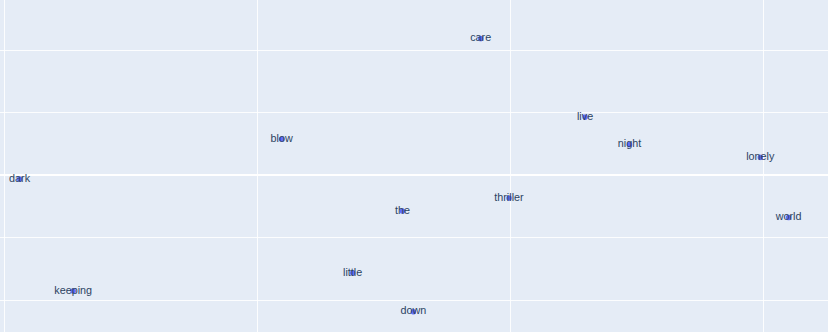

Se observa que las palabras live, world, care están cerca. Son términos que aparecen por ejemplo en la canción *"Heal The World"* donde aparecen muchas veces. Thriller y night también estan cerca, probablemente debido a la canción *"Thriller"*.

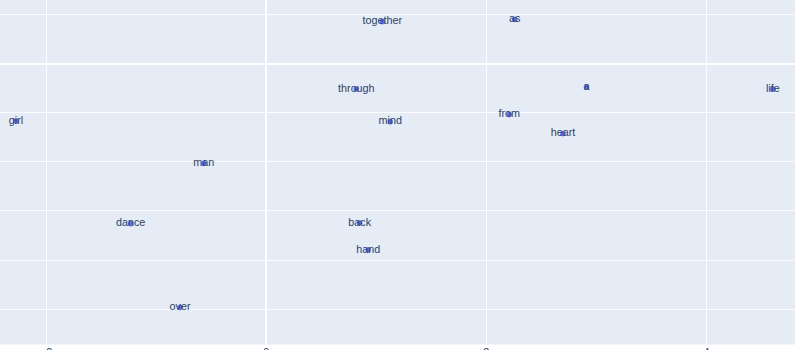

Se encuentran agrupados términos relacionados más al movimiento o que se usan frecuentemente cuando se refiere al baile como back, hand, over. Por otro lado tambien se agrupan términos como through, together, heart, mind que suele aparecer en canciones con mensajes sociales.